# Import Library

In [ ]:
import numpy as np
import pandas as pd

import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


# Import .csv to SQL

We want to do this to create a database (although this might not be necessary for quick modeling), but usually we import from an SQL database. Hence, this illustration.

In [ ]:
df=pd.read_csv("/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv",sep=",")

In [ ]:
import sqlite3

# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')
df.to_sql('healthcare_data', conn, index=False, if_exists='replace')

70692

# Explanatory Data Analysis

Features mapping (8 features, 1 target):
- Sex: 0 = Female, 1 = Male (Binary)
- BMI: Body Mass Index (Float)
- PhysActivity: 0 = No exercise, 1 = Exercise (Binary)
- Age: 5-year group category (Ordinal), ex: 1 = 18-24, 2 = 25-29, 3 = 30-34, ..., 12 = 75-79, 13 = 80+
- Fruits: 0 = No fruits, 1 = Eat fruits
- Veggies: 0 = No vegetables, 1 = Eat vegetables
- Smoker: 0 = Don't smoke, 1 = Smoke
- HvyAlcoholConsump: 0 = Don't drink, 1 = Drink
- Diabetes_binary: Physical blood diabetes test


In [ ]:
# Query the database
query = '''SELECT
           Diabetes_binary,
           COUNT(*) as samples,
           COUNT(CASE WHEN Sex = 0 THEN 1 END) as female_samples,
           COUNT(CASE WHEN Sex = 1 THEN 1 END) as male_samples,
           AVG(BMI) as AVG_BMI,
           SUM(CASE WHEN PhysActivity = 0 THEN 1 ELSE 0 END) as lack_exercise,
           AVG(Age) as AVG_Age,
           SUM(CASE WHEN Fruits = 0 THEN 1 ELSE 0 END) as lack_fruit,
           SUM(CASE WHEN Veggies = 0 THEN 1 ELSE 0 END) as lack_veggies,
           SUM(CASE WHEN Smoker = 1 THEN 1 ELSE 0 END) as smoker,
           SUM(CASE WHEN HvyAlcoholConsump = 1 THEN 1 ELSE 0 END) as alcohol_drinker
           FROM healthcare_data
           GROUP BY 1
           ORDER BY 1 ASC
           '''
df_stats = pd.read_sql(query, conn)
df_stats

,Diabetes_binary,samples,female_samples,male_samples,AVG_BMI,lack_exercise,AVG_Age,lack_fruit,lack_veggies,smoker,alcohol_drinker
0,0.0,35346,19975,15371,27.769960,7934,7.789057,12790,6322,15281,2188
1,1.0,35346,18411,16935,31.944011,13059,9.379053,14653,8610,18317,832


# Import for Modelling

In [ ]:
# Query the database
query = 'SELECT Sex, BMI, PhysActivity, Age, Fruits, Veggies, Smoker, HvyAlcoholConsump,  Diabetes_binary FROM healthcare_data;'
df_sql = pd.read_sql(query, conn)
df_sql

,Sex,BMI,PhysActivity,Age,Fruits,Veggies,Smoker,HvyAlcoholConsump,Diabetes_binary
0,1.0,26.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0
1,1.0,26.0,0.0,12.0,1.0,0.0,1.0,0.0,0.0
2,1.0,26.0,1.0,13.0,1.0,1.0,0.0,0.0,0.0
3,1.0,28.0,1.0,11.0,1.0,1.0,1.0,0.0,0.0
4,0.0,29.0,1.0,8.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
70687,0.0,37.0,0.0,6.0,0.0,1.0,0.0,0.0,1.0
70688,1.0,29.0,0.0,10.0,1.0,1.0,1.0,0.0,1.0
70689,0.0,25.0,0.0,13.0,1.0,0.0,0.0,0.0,1.0
70690,0.0,18.0,0.0,11.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
print(df_sql['Diabetes_binary'].value_counts())

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64


# Preprocessing

In [ ]:
X = df_sql[['Sex', 'BMI', 'PhysActivity', 'Age', 'Fruits', 'Veggies', 'Smoker', 'HvyAlcoholConsump']]
y = df_sql['Diabetes_binary']

We want to split the raw data into a training set and a test set in an 80:20 ratio. From the 80% training set, we further want to split it into a training set and a validation set in an 80:20 ratio. An illustration can be seen in the image below

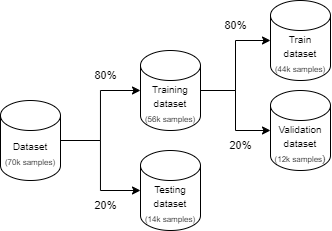



In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y,random_state=0,test_size=0.2,shuffle=True,stratify=y)

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y,random_state=0,test_size=0.2,shuffle=True,stratify=y)

In [ ]:
X_train, X_val, y_train, y_val =train_test_split(X_train, y_train,random_state=0,test_size=0.2,shuffle=True,stratify=y_train)

In [ ]:
print('Train')
print(y_train.value_counts())
print('\nValidation')
print(y_val.value_counts())
print('\nTest')
print(y_test.value_counts())

Train
Diabetes_binary
0.0    22621
1.0    22621
Name: count, dtype: int64

Validation
Diabetes_binary
1.0    5656
0.0    5655
Name: count, dtype: int64

Test
Diabetes_binary
0.0    7070
1.0    7069
Name: count, dtype: int64


# Modelling

In [ ]:
clf = lgbm.LGBMClassifier(random_state=42,
                         is_unbalance=True,
                         verbosity=1)
clf.fit(X_train, y_train)

y_pred_proba=clf.predict_proba(X_val)
fpr_lgbm, tpr_lgbm, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_lgbm = metrics.auc(fpr_lgbm, tpr_lgbm)
print(auc_lgbm)

y_pred_proba=clf.predict_proba(X_test)
fpr_sample_lgbm, tpr_sample_lgbm, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_lgbm = metrics.auc(fpr_sample_lgbm, tpr_sample_lgbm)
print(auc_sample_lgbm)

[LightGBM] [Info] Number of positive: 22621, number of negative: 22621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 45242, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.7590622916971499
0.7679190853224319


In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=2, loss_function='Logloss', random_state = 42)

# Train the CatBoost classifier
clf.fit(X_train, y_train, verbose=0)

# Make predictions
y_pred_proba = clf.predict_proba(X_val)
fpr_cat, tpr_cat, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_cat = metrics.auc(fpr_cat, tpr_cat)
print(auc_cat)

y_pred_proba = clf.predict_proba(X_test)
fpr_sample_cat, tpr_sample_cat, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_cat = metrics.auc(fpr_sample_cat, tpr_sample_cat)
print(auc_sample_cat)

0.7589743120769068
0.7687248926173865


In [ ]:
import xgboost as xgb

clf = xgb.XGBClassifier(random_state=42)

#Training the model on the training data
clf.fit(X_train, y_train)

#Making predictions on the test set
y_pred_proba = clf.predict_proba(X_val)
fpr_xgb, tpr_xgb, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
print(auc_xgb)

y_pred_proba = clf.predict_proba(X_test)
fpr_sample_xgb, tpr_sample_xgb, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_xgb = metrics.auc(fpr_sample_xgb, tpr_sample_xgb)
print(auc_sample_xgb)

0.7560734076439095
0.7647904780979887


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=2, random_state=42)
clf_rf.fit(X_train, y_train)

y_pred_proba=clf_rf.predict_proba(X_val)
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_rf = metrics.auc(fpr_rf, tpr_rf)
print(auc_rf)

y_pred_proba=clf_rf.predict_proba(X_test)
fpr_sample_rf, tpr_sample_rf, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_rf = metrics.auc(fpr_sample_rf, tpr_sample_rf)
print(auc_sample_rf)

0.7350655688911066
0.7461226007611775


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree classifier
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_val)
fpr_dt, tpr_dt, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_dt = metrics.auc(fpr_dt, tpr_dt)
print(auc_dt)

y_pred_proba = clf.predict_proba(X_test)
fpr_sample_dt, tpr_sample_dt, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_dt = metrics.auc(fpr_sample_dt, tpr_sample_dt)
print(auc_sample_dt)

0.6870581322057935
0.6935456181270775


# Modelling Result Plot

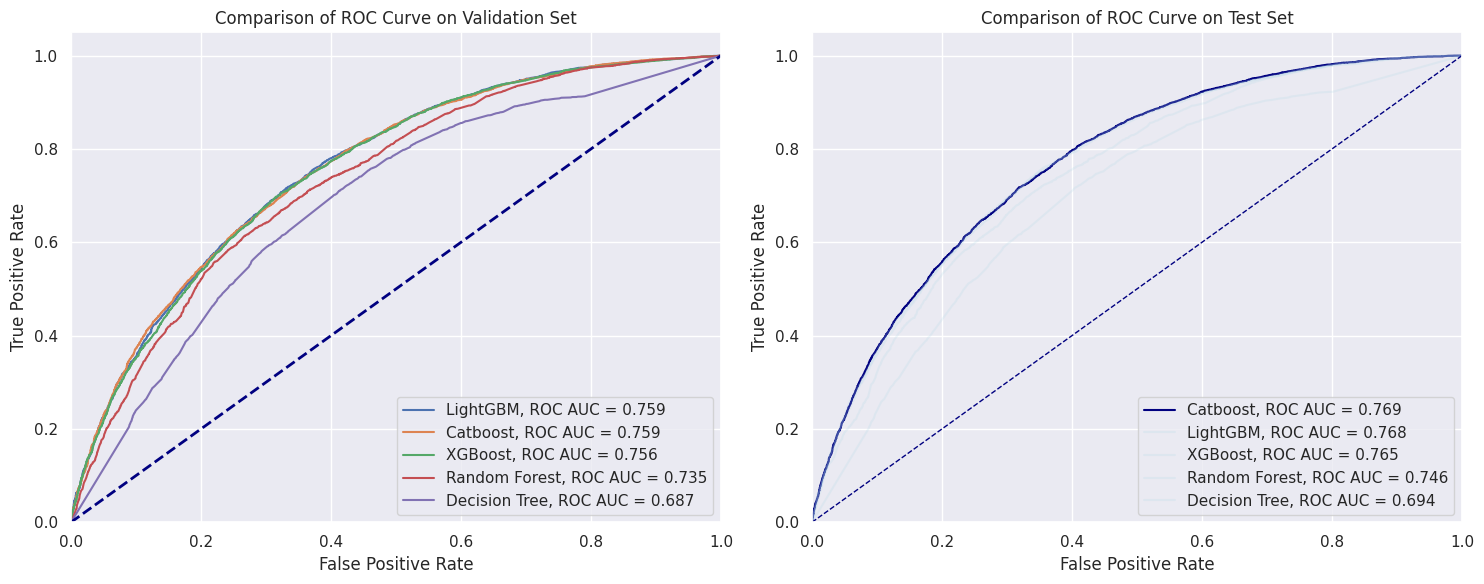

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcdefaults()
sns.reset_defaults()
sns.set_theme()
sns.color_palette()

# Calculate AUC values and store them in dictionaries for both sets
auc_values_train = {
    'cat': auc_cat,
    'rf': auc_rf,
    'lgbm': auc_lgbm,
    'xgb': auc_xgb,
    'dt': auc_dt
}

auc_values_test = {
    'cat': auc_sample_cat,
    'rf': auc_sample_rf,
    'lgbm': auc_sample_lgbm,
    'xgb': auc_sample_xgb,
    'dt': auc_sample_dt
}

models = {
    'cat': 'Catboost',
    'rf': 'Random Forest',
    'lgbm': 'LightGBM',
    'xgb': 'XGBoost',
    'dt': 'Decision Tree'
}

# Sort AUC values in descending order and get the corresponding keys (model names)
sorted_models_train = sorted(auc_values_train, key=auc_values_train.get, reverse=True)
sorted_models_test = sorted(auc_values_test, key=auc_values_test.get, reverse=True)

# Create a figure and two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for training set
for model in sorted_models_train:
    fpr, tpr = globals()["fpr_" + model.lower()], globals()["tpr_" + model.lower()]
    auc = auc_values_train[model]
    ax1.plot(fpr, tpr, label=f"{models[model]}, ROC AUC = {auc:.3f}")

ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Comparison of ROC Curve on Validation Set')
ax1.grid(True)
ax1.legend(loc='lower right')

# Plot for test set
for i, model in enumerate(sorted_models_test):
    fpr, tpr = globals()["fpr_sample_" + model.lower()], globals()["tpr_sample_" + model.lower()]
    auc = auc_values_test[model]
    if i == 0:
        ax2.plot(fpr, tpr, label=f"{models[model]}, ROC AUC = {auc:.3f}", color='navy')
    else:
        ax2.plot(fpr, tpr, label=f"{models[model]}, ROC AUC = {auc:.3f}", color='lightblue', alpha=0.2)

ax2.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Comparison of ROC Curve on Test Set')
ax2.grid(True)
ax2.legend(loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Pick the best Model

In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=2, loss_function='Logloss', random_state = 42)

# Train the CatBoost classifier
clf.fit(X_train, y_train, verbose=0)

# Make predictions
y_pred_proba = clf.predict_proba(X_val)
fpr_cat, tpr_cat, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_cat = metrics.auc(fpr_cat, tpr_cat)
print(auc_cat)

y_pred_proba = clf.predict_proba(X_test)
fpr_sample_cat, tpr_sample_cat, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_cat = metrics.auc(fpr_sample_cat, tpr_sample_cat)
print(auc_sample_cat)

0.7589743120769068
0.7687248926173865


In [ ]:
y_df = pd.Series(y_pred_proba[:,1], name='prediction')

combined = pd.concat([X_test.reset_index(), y_df], axis=1)

combined['label_predicted'] = np.where(combined['prediction'] > 0.5, 1, 0)

display(combined)

,index,Sex,BMI,PhysActivity,Age,Fruits,Veggies,Smoker,HvyAlcoholConsump,prediction,label_predicted
0,68449,1.0,27.0,1.0,10.0,0.0,0.0,1.0,0.0,0.594978,1
1,13218,1.0,20.0,1.0,13.0,1.0,1.0,0.0,0.0,0.369369,0
2,63809,0.0,25.0,1.0,12.0,1.0,1.0,0.0,0.0,0.438305,0
3,54114,1.0,32.0,1.0,11.0,0.0,1.0,1.0,0.0,0.738117,1
4,16639,0.0,29.0,1.0,12.0,1.0,1.0,0.0,1.0,0.413121,0
...,...,...,...,...,...,...,...,...,...,...,...
14134,26874,0.0,27.0,1.0,9.0,1.0,1.0,0.0,0.0,0.428454,0
14135,52351,1.0,39.0,1.0,8.0,0.0,0.0,0.0,0.0,0.738513,1
14136,69103,0.0,30.0,1.0,10.0,0.0,1.0,0.0,0.0,0.580202,1
14137,49021,1.0,30.0,1.0,6.0,1.0,1.0,0.0,0.0,0.347673,0


# Threshold

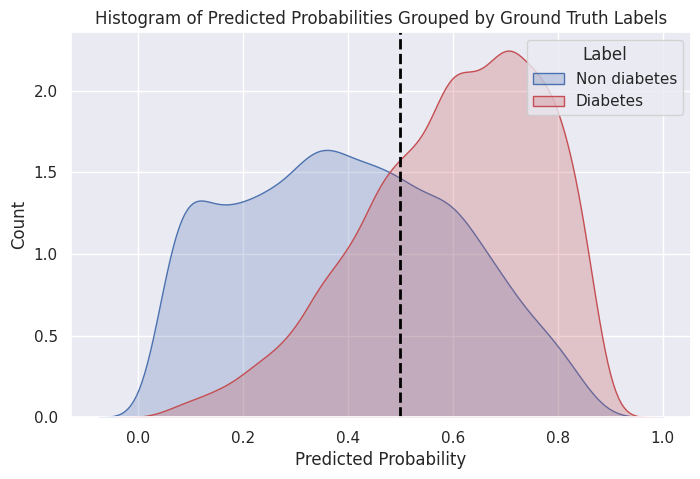

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



dfplot = pd.DataFrame({'proba': y_pred_proba[:,1], 'label': y_test})
dfplot['label_str'] = dfplot['label'].map({0: 'non diabetes', 1: 'diabetes'})
palette = {'non diabetes': sns.color_palette()[0], 'diabetes': sns.color_palette()[3]}

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(data=dfplot, x='proba', hue='label_str', fill=True, common_norm=False, palette=palette)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Histogram of Predicted Probabilities Grouped by Ground Truth Labels')
plt.legend(title='Label', labels=['Non diabetes', 'Diabetes'])
plt.show()


# Feature importance

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

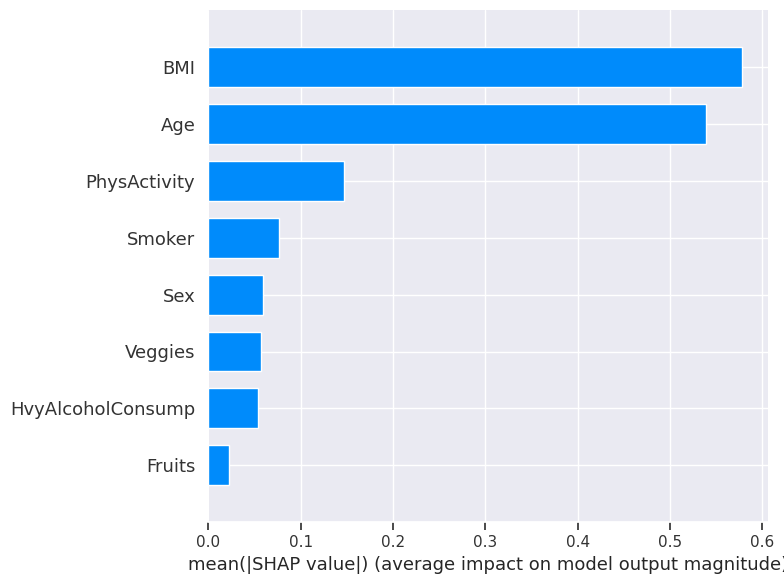

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", plot_size=[8,6])

In [ ]:
# Get feature importance
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a list of tuples with feature names and their importance
feature_importance_list = [(feature, importance) for feature, importance in zip(X_train.columns, feature_importance)]

# Sort the list by importance (descending order)
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Create a list of only feature names
feature_names = [feature for feature, _ in feature_importance_list]

# Print or use the feature names list as needed
print(feature_names)

['BMI', 'Age', 'PhysActivity', 'Smoker', 'Sex', 'Veggies', 'HvyAlcoholConsump', 'Fruits']


In [ ]:
AUC_LIST = []
AUC_PR_LIST = []
selected_features = []

for feature in feature_names:
        selected_features.append(feature)



        clf_test = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=2,
                                      loss_function='Logloss', random_state = 42)
        clf_test.fit(X_train[selected_features], y_train)
        y_pred_sample_proba=clf_test.predict_proba(X_val[selected_features])
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_sample_proba[:,1])
        print('AUC:', metrics.auc(fpr, tpr))
        AUC_LIST.append(metrics.auc(fpr, tpr))
        lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, y_pred_sample_proba[:,1])
        print('AUC PR:', metrics.auc(lr_recall, lr_precision))
        AUC_PR_LIST.append(metrics.auc(lr_recall, lr_precision))


# Modify the first item
feature_names[0] = str(feature_names[0]) + '(#variable = 1)'
feature_names[1] = str(feature_names[1]) + '(#variable = 2)'

length_of_feature = len(feature_names)

# Modify the last item
feature_names[-1] = str(feature_names[-1]) + '(#variable = ' + str(length_of_feature) + ')'

0:	learn: 0.6848610	total: 4.87ms	remaining: 482ms
1:	learn: 0.6776533	total: 9.99ms	remaining: 489ms
2:	learn: 0.6713307	total: 14.8ms	remaining: 478ms
3:	learn: 0.6658199	total: 18.6ms	remaining: 446ms
4:	learn: 0.6611584	total: 22.7ms	remaining: 431ms
5:	learn: 0.6574509	total: 27.1ms	remaining: 425ms
6:	learn: 0.6545041	total: 31.3ms	remaining: 416ms
7:	learn: 0.6521373	total: 34.9ms	remaining: 402ms
8:	learn: 0.6499505	total: 44.8ms	remaining: 453ms
9:	learn: 0.6479585	total: 48.8ms	remaining: 439ms
10:	learn: 0.6465150	total: 55.7ms	remaining: 451ms
11:	learn: 0.6450680	total: 64ms	remaining: 469ms
12:	learn: 0.6437423	total: 68.2ms	remaining: 456ms
13:	learn: 0.6427095	total: 72.3ms	remaining: 444ms
14:	learn: 0.6418068	total: 80.2ms	remaining: 455ms
15:	learn: 0.6411040	total: 83.7ms	remaining: 439ms
16:	learn: 0.6406023	total: 87.3ms	remaining: 426ms
17:	learn: 0.6401594	total: 91.3ms	remaining: 416ms
18:	learn: 0.6396910	total: 95ms	remaining: 405ms
19:	learn: 0.6394474	total

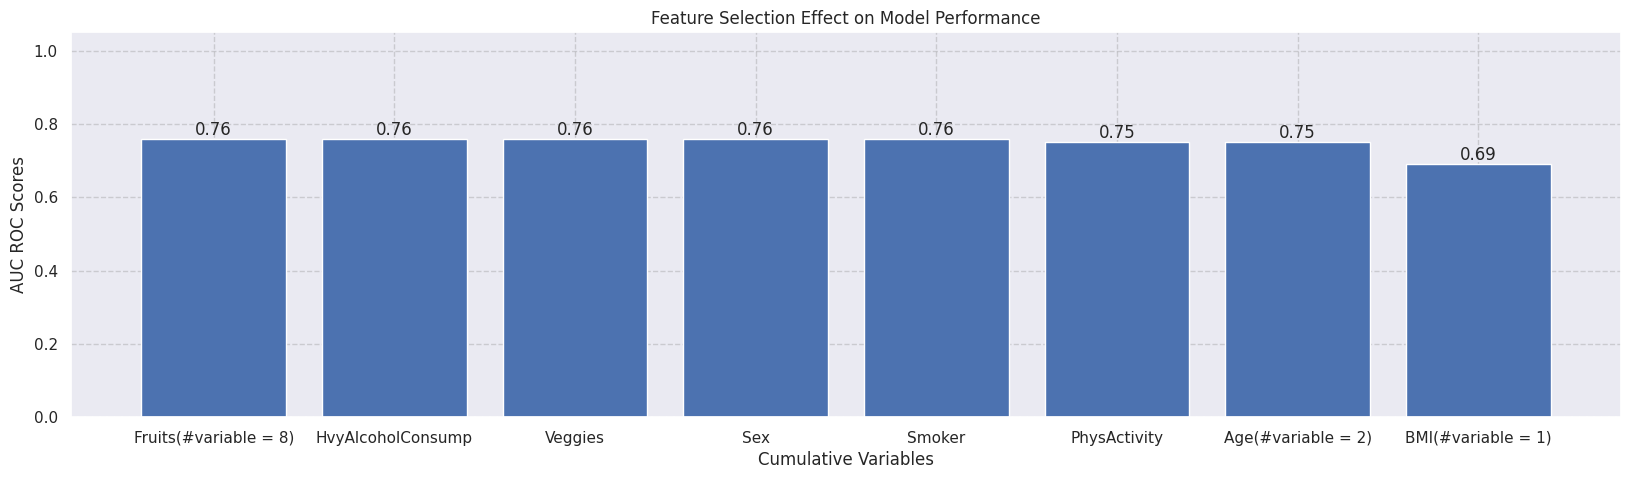

In [ ]:
import matplotlib.pyplot as plt

feature_names.reverse()
AUC_LIST.reverse()

xticks = range(len(feature_names))
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(x=xticks, height=np.round(AUC_LIST,2))
ax.grid(True, alpha=0.3, linestyle='--', zorder=3, color='gray')
ax.set_ylim([0.0, 1.05])
ax.set_xticks(xticks, feature_names, rotation=0)
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Cumulative Variables')
plt.ylabel('AUC ROC Scores')
plt.title('Feature Selection Effect on Model Performance')
plt.show()

# Picking optimal model

In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=2, loss_function='Logloss', random_state = 42)

# Train the CatBoost classifier
clf.fit(X_train[['BMI', 'Age', 'PhysActivity', 'Smoker']], y_train, verbose=0)

# Make predictions
y_pred_proba = clf.predict_proba(X_val)
fpr_cat, tpr_cat, thresholds = metrics.roc_curve(y_val, y_pred_proba[:,1])
auc_cat = metrics.auc(fpr_cat, tpr_cat)
print(auc_cat)

y_pred_proba = clf.predict_proba(X_test)
fpr_sample_cat, tpr_sample_cat, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc_sample_cat = metrics.auc(fpr_sample_cat, tpr_sample_cat)
print(auc_sample_cat)

y_df = pd.Series(y_pred_proba[:,1], name='prediction')

combined = pd.concat([X_test.reset_index(), y_df], axis=1)

combined['label_predicted'] = np.where(combined['prediction'] > 0.5, 1, 0)
combined['string_label_predicted'] = combined['label_predicted'].map({0: 'Non Diabetes', 1: 'Diabetes'})
combined['string_label_predicted'] = pd.Categorical(combined['string_label_predicted'], categories=['Non Diabetes', 'Diabetes'], ordered=True)

0.7550740229384818
0.7627090551950735


# Intrepreting the model

In [ ]:
import os
from catboost import CatBoost, Pool

X = X_train[['BMI', 'Age', 'PhysActivity', 'Smoker']]
y = y_train

is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))

# Define the path where you want to create the folder
path = "tree_plot"

# Create the directory
os.makedirs(path, exist_ok=True)

clf.plot_tree(
    tree_idx=0,
    pool=pool
).save('tree_plot/tree_idx_001.gv')
clf.plot_tree(
    tree_idx=49,
    pool=pool
).save('tree_plot/tree_idx_050.gv')
clf.plot_tree(
    tree_idx=99,
    pool=pool
).save('tree_plot/tree_idx_100.gv')

print("Plot done")


Plot done


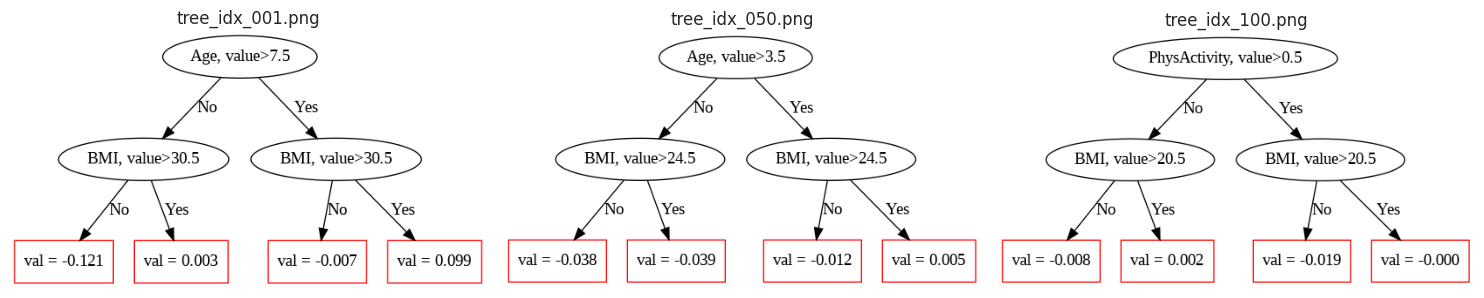

In [ ]:
import os
import subprocess
import matplotlib.pyplot as plt
from PIL import Image

# Function to convert .gv file to image
def convert_to_image(input_file, output_file, image_format='png'):
    subprocess.run(['dot', '-T' + image_format, input_file, '-o', output_file])

# List of .gv files in the folder
# Specify the folder path
folder_path = 'tree_plot'

# List all PNG files in the folder
gv_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.gv')])
output_images = []

# Convert each .gv file to PNG
for gv_file in gv_files:
    image_file = gv_file.replace('.gv', '.png')
    convert_to_image('tree_plot/' + gv_file, 'tree_plot/' + image_file)
    output_images.append(image_file)

# Plot all images using Matplotlib
fig, axs = plt.subplots(1, len(output_images), figsize=(15, 5))  # Adjust figsize as needed

for i, image_file in enumerate(output_images):
    img = Image.open('tree_plot/' + image_file)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(os.path.basename(image_file))

plt.tight_layout()
plt.show()

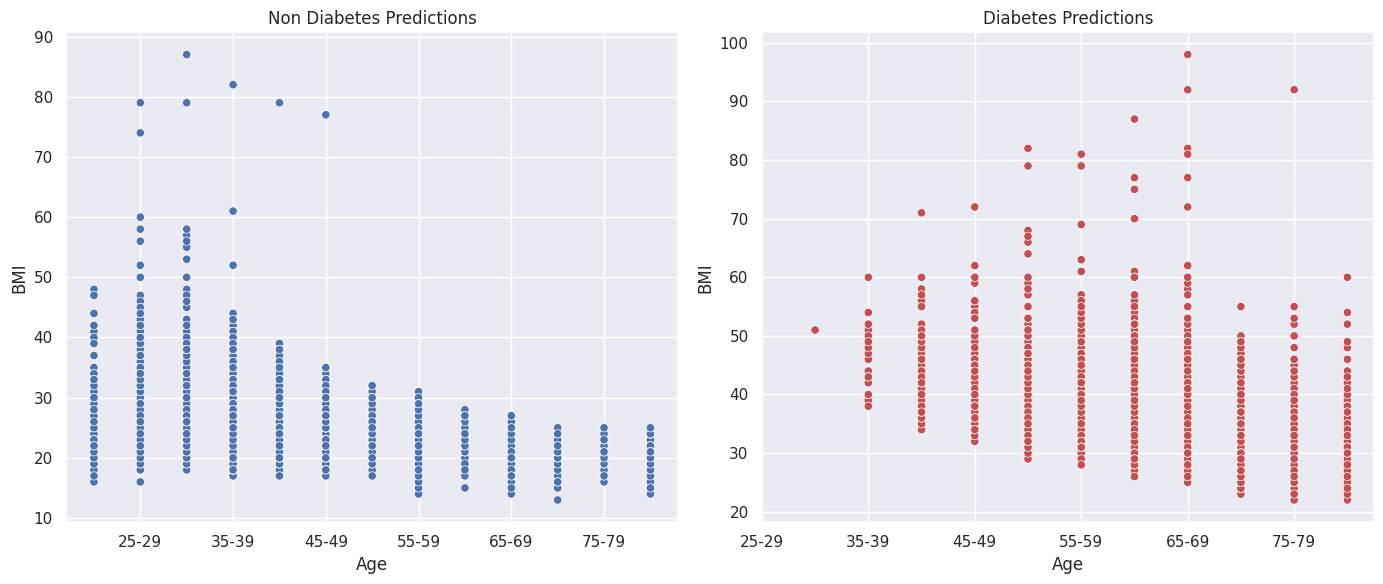

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Define a custom color palette
palette = {'Non Diabetes': sns.color_palette()[0], 'Diabetes': sns.color_palette()[3]}



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=combined[combined['string_label_predicted'] == 'Non Diabetes'], x='Age', y='BMI', hue='string_label_predicted', palette=palette, ax=ax1, legend=False)
ax1.set_title('Non Diabetes Predictions')
ax1.set_xlabel('Age')
ax1.set_ylabel('BMI')
ax1.set_xticks([2, 4, 6, 8, 10, 12])
ax1.set_xticklabels(['25-29', '35-39', '45-49', '55-59', '65-69', '75-79'])
ax1.grid(True)


sns.scatterplot(data=combined[combined['string_label_predicted'] == 'Diabetes'], x='Age', y='BMI', hue='string_label_predicted', palette=palette, ax=ax2, legend=False)
ax2.set_title('Diabetes Predictions')
ax2.set_xlabel('Age')
ax2.set_ylabel('BMI')
ax2.set_xticks([2, 4, 6, 8, 10, 12])
ax2.set_xticklabels(['25-29', '35-39', '45-49', '55-59', '65-69', '75-79'])
ax2.grid(True)


plt.tight_layout()
plt.show()


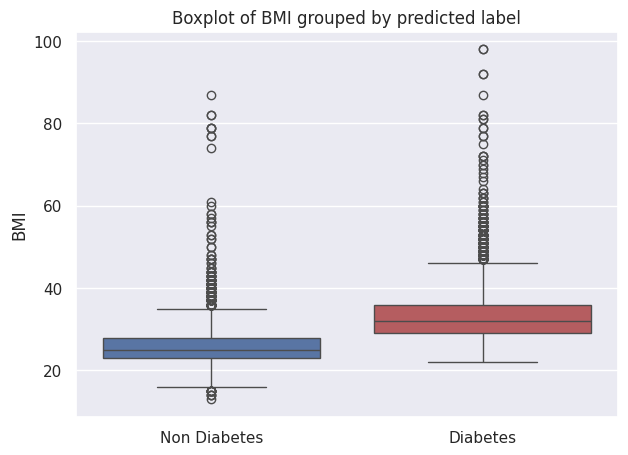

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcdefaults()
sns.reset_defaults()
sns.set_theme()

palette = {'Non Diabetes': sns.color_palette()[0], 'Diabetes': sns.color_palette()[3]}



plt.figure(figsize=(7, 5))
sns.boxplot(x='string_label_predicted', y='BMI', hue='string_label_predicted', data=combined, palette=palette)
plt.title('Boxplot of BMI grouped by predicted label')
plt.xlabel('')
plt.show()

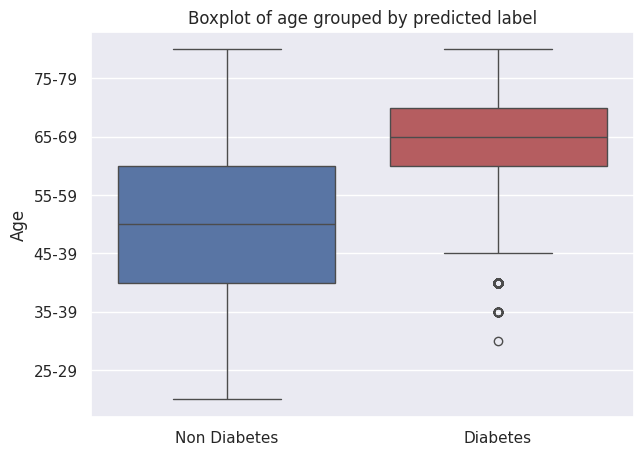

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

palette = {'Non Diabetes': sns.color_palette()[0], 'Diabetes': sns.color_palette()[3]}

plt.figure(figsize=(7, 5))
sns.boxplot(x='string_label_predicted', y='Age', data=combined, hue='string_label_predicted', palette=palette)
plt.title('Boxplot of age grouped by predicted label')
plt.yticks([2, 4, 6, 8, 10, 12], ['25-29','35-39','45-39','55-59', '65-69', '75-79'])
plt.xlabel('')
plt.show()

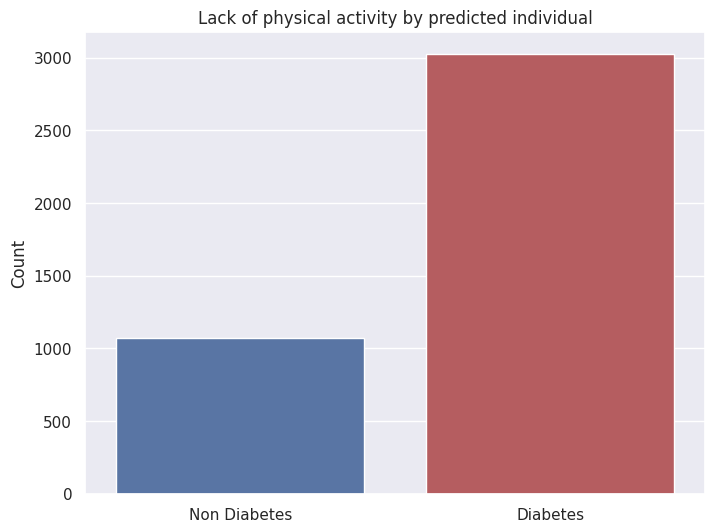

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filter = combined[combined['PhysActivity']==0]

grouped = df_filter.groupby(['string_label_predicted']).size().reset_index(name='count')


plt.figure(figsize=(8, 6))
sns.barplot(x='string_label_predicted', y='count', data=grouped, hue='string_label_predicted', palette=palette)
plt.title('Lack of physical activity by predicted individual')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

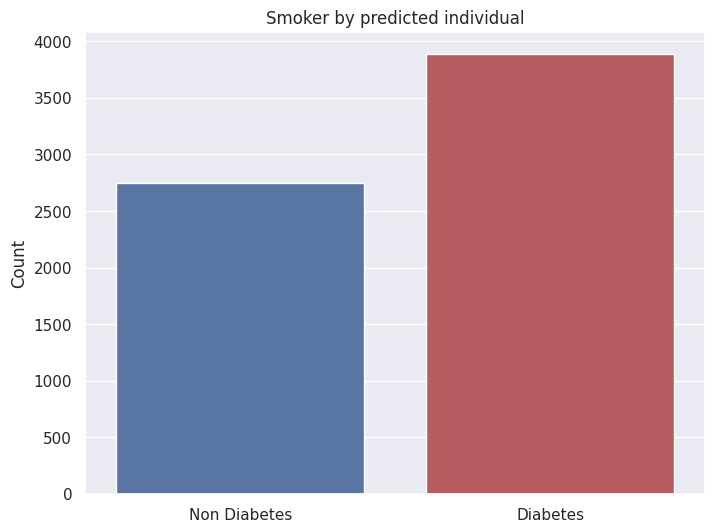

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filter = combined[combined['Smoker']==1]

grouped = df_filter.groupby(['string_label_predicted']).size().reset_index(name='count')


plt.figure(figsize=(8, 6))
sns.barplot(x='string_label_predicted', y='count', data=grouped, hue='string_label_predicted', palette=palette)
plt.title('Smoker by predicted individual')
# plt.xlabel('Lack of physical activity in DM predicted individual')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

# Save model for Deployment

In [ ]:
import pickle
with open('Catboost_diabetes.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

num_samples = 100

sample = {
    'BMI': np.random.uniform(18.5, 40.0, num_samples), # BMI between 18.5 and 40.0
    'Age': np.random.randint(18, 80, num_samples),     # Age between 18 and 80
    'PhysActivity': np.random.randint(0, 2, num_samples), # PhysActivity either 0 or 1
    'Smoker': np.random.randint(0, 2, num_samples)     # Smoker either 0 or 1
}

sample_df = pd.DataFrame(sample)

display(sample_df.head())

,BMI,Age,PhysActivity,Smoker
0,26.552613,49,0,0
1,38.940358,56,1,0
2,34.237870,66,1,1
3,31.371157,69,0,1
4,21.854401,78,1,1


In [ ]:
with open('Catboost_diabetes.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predictions = loaded_model.predict(sample_df)

In [ ]:
predictions

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

In [ ]:
predictions = predictions.astype(int)

# Using numpy.bincount to count occurrences
counts = np.bincount(predictions)


for value, count in enumerate(counts):
    if value == 0:
      label = 'Non diabetes individual:'
    else:
      label = 'Diabetes individual:'
    print(f"{label} {count} Individual")

Non diabetes individual: 29 Individual
Diabetes individual: 71 Individual
